In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, pandas as pd, numpy as np
!pip -q install openpyxl

ROOT = "/content/drive/MyDrive/msc_final_dataset"
CANDIDATES = [
    f"{ROOT}/final_reclassified.csv",
    f"{ROOT}/final_with_images_ocr.csv",
]

DATA = next((p for p in CANDIDATES if os.path.exists(p)), None)
assert DATA, f"Could not find any of: {CANDIDATES}"
print("Using dataset:", DATA)

# Output folders/files
OUT_DIR = f"{ROOT}/chapter4_outputs"
FIG_DIR = f"{OUT_DIR}/figures"
os.makedirs(FIG_DIR, exist_ok=True)

XLSX_PATH = f"{OUT_DIR}/chapter4_descriptives.xlsx"
KEY_STATS = f"{OUT_DIR}/chapter4_key_stats.csv"

# Load
df = pd.read_csv(DATA)
print("Rows:", len(df))
print("Columns:", df.columns.tolist())

Mounted at /content/drive
Using dataset: /content/drive/MyDrive/msc_final_dataset/final_reclassified.csv
Rows: 5966
Columns: ['Text', 'Emotion_Label', 'Emoji', 'Image_Reference', 'Subcommunity_Tag', 'Modality_Type', 'Social_Media_Type', 'Source', 'Image_Local_Path', 'local_path', 'status', 'OCR_Text', 'Text_Combined', 'Emoji_Extracted']


In [ ]:
# Display Stats/Descriptives of Dataset:

import re

# Safe string columns
for col in ["Text","OCR_Text","Text_Combined","Emoji","Subcommunity_Tag","Emotion_Label","Modality_Type","Social_Media_Type"]:
    if col in df.columns:
        df[col] = df[col].astype(str).replace({"nan":"", "None":""}).fillna("")

# If Text_Combined not present, build it
if "Text_Combined" not in df.columns:
    t = (df["Text"] if "Text" in df.columns else "").astype(str)
    o = (df["OCR_Text"] if "OCR_Text" in df.columns else "").astype(str)
    df["Text_Combined"] = (t + " " + o).str.strip()

# Initial basic distributions
platform_counts   = df["Social_Media_Type"].value_counts(dropna=False).rename("count").to_frame()
modality_counts   = df["Modality_Type"].value_counts(dropna=False).rename("count").to_frame()
subcomm_top       = df["Subcommunity_Tag"].value_counts(dropna=False).head(10).rename("count").to_frame()

# Platform & Modality
platform_x_mod    = pd.crosstab(df["Social_Media_Type"], df["Modality_Type"]).sort_index()

# Data text length stats
df["text_chars"]  = df["Text_Combined"].astype(str).str.len()
df["text_words"]  = df["Text_Combined"].astype(str).str.split().apply(len)

desc_text_chars   = df["text_chars"].describe().to_frame(name="text_chars")
desc_text_words   = df["text_words"].describe().to_frame(name="text_words")

# Emoji stats (+more emojis)
emoji_str = df["Emoji"].astype(str).fillna("")
has_emoji = emoji_str.str.strip().ne("")
df["emoji_count"] = emoji_str.apply(lambda s: len([ch for ch in s if ch.strip() != ""]))
df["emoji_per_100chars"] = np.where(df["text_chars"]>0, df["emoji_count"] / df["text_chars"] * 100, 0.0)
desc_emoji_density = df.loc[has_emoji, "emoji_per_100chars"].describe().to_frame(name="emoji_per_100chars")

##Missing vals (selected columns)
cols_for_missing = ["Text","OCR_Text","Text_Combined","Emoji","Image_Reference","Image_Local_Path","Emotion_Label","Modality_Type","Social_Media_Type","Subcommunity_Tag"]
present = {c: (c in df.columns) for c in cols_for_missing}
miss_tbl = pd.DataFrame({
    "column": [c for c in cols_for_missing if present.get(c, False)],
    "missing": [int(df[c].replace({"":np.nan}).isna().sum()) for c in cols_for_missing if present.get(c, False)],
    "missing_rate": [float(df[c].replace({"":np.nan}).isna().mean()) for c in cols_for_missing if present.get(c, False)]
}).sort_values("missing_rate", ascending=False).reset_index(drop=True)

#Save key stats CSV (for writing initial analysis<<)
key_stats = {
    "N_rows": [len(df)],
    "Has_emoji_rows": [int(has_emoji.sum())],
    "Has_image_rows": [int(df.get("Image_Local_Path","").astype(str).str.strip().ne("").sum()) if "Image_Local_Path" in df.columns else 0],
    "Has_OCR_text_rows": [int(df.get("OCR_Text","").astype(str).str.strip().ne("").sum()) if "OCR_Text" in df.columns else 0],
    "Mean_words_per_post": [float(df["text_words"].mean())],
    "Median_words_per_post": [float(df["text_words"].median())],
}
pd.DataFrame(key_stats).to_csv(KEY_STATS, index=False)

# SAVE Excel workbook with all sheets of data (push to github!!)
with pd.ExcelWriter(XLSX_PATH, engine="openpyxl") as xl:
    platform_counts.to_excel(xl, sheet_name="platform_counts")
    modality_counts.to_excel(xl, sheet_name="modality_counts")
    platform_x_mod.to_excel(xl, sheet_name="platform_x_modality")
    subcomm_top.to_excel(xl, sheet_name="top_subcommunities")
    desc_text_words.to_excel(xl, sheet_name="desc_text_words")
    desc_text_chars.to_excel(xl, sheet_name="desc_text_chars")
    df["emoji_count"].describe().to_frame(name="emoji_count").to_excel(xl, sheet_name="desc_emoji_count")
    desc_emoji_density.to_excel(xl, sheet_name="emoji_density")
    miss_tbl.to_excel(xl, sheet_name="missingness", index=False)

print("Saved:", XLSX_PATH)
print("Saved:", KEY_STATS)

# Display results - column header/stats/text length
display(platform_counts.head())
display(modality_counts.head())
display(platform_x_mod)
display(subcomm_top)
display(desc_text_words.T)
display(desc_text_chars.T)
display(miss_tbl.head())

Saved: /content/drive/MyDrive/msc_final_dataset/chapter4_outputs/chapter4_descriptives.xlsx
Saved: /content/drive/MyDrive/msc_final_dataset/chapter4_outputs/chapter4_key_stats.csv


,count
Social_Media_Type,
Twitter,5000
Reddit,966


,count
Modality_Type,
Text-only,5475
Text+Image,491


Modality_Type,Text+Image,Text-only
Social_Media_Type,,
Reddit,476,490
Twitter,15,4985


,count
Subcommunity_Tag,
Twitter,5000
wholesomememes,250
relationships,248
memes,244
offmychest,224


,count,mean,std,min,25%,50%,75%,max
text_words,5966.0,45.380322,141.063762,1.0,8.0,13.0,21.0,2456.0


,count,mean,std,min,25%,50%,75%,max
text_chars,5966.0,237.396916,736.504855,3.0,41.0,70.0,110.0,12812.0


,column,missing,missing_rate
0,Emotion_Label,5929,0.993798
1,Emoji,5886,0.986591
2,OCR_Text,5590,0.936976
3,Image_Local_Path,5504,0.922561
4,Image_Reference,5475,0.917700


from matplotlib import pyplot as plt
subcomm_top['count'].plot(kind='hist', bins=20, title='count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
subcomm_top['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

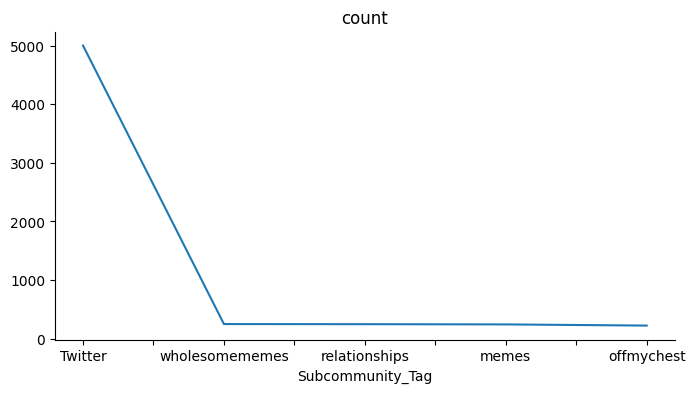

In [ ]:
from matplotlib import pyplot as plt
subcomm_top['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

Plot visual analysis:
Graphs
Figures

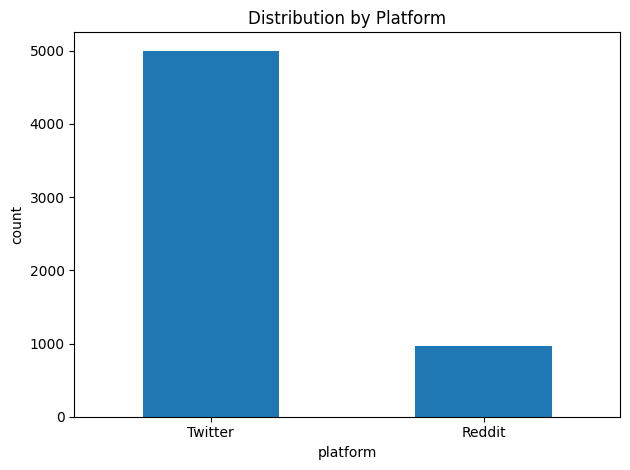

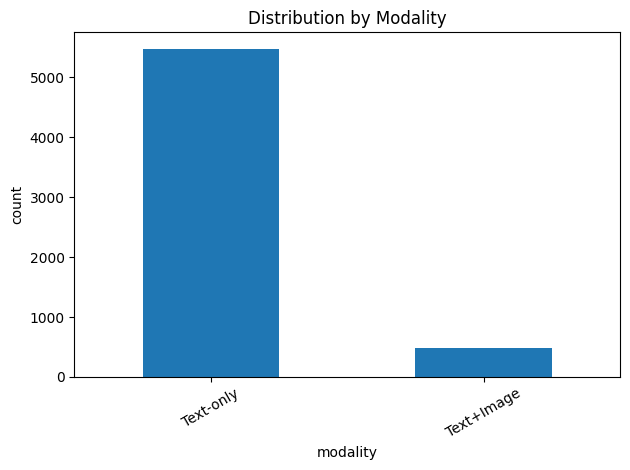

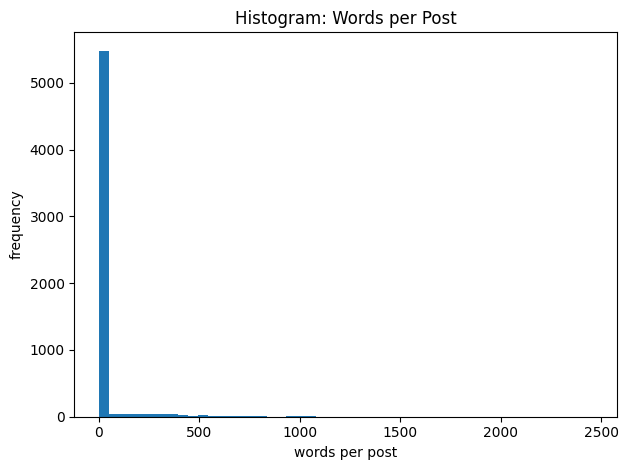

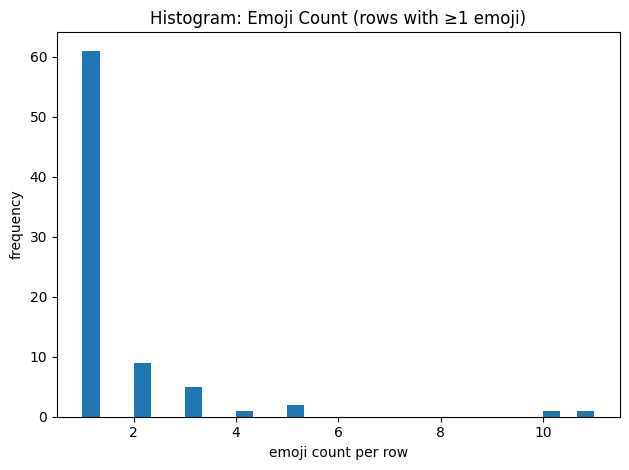

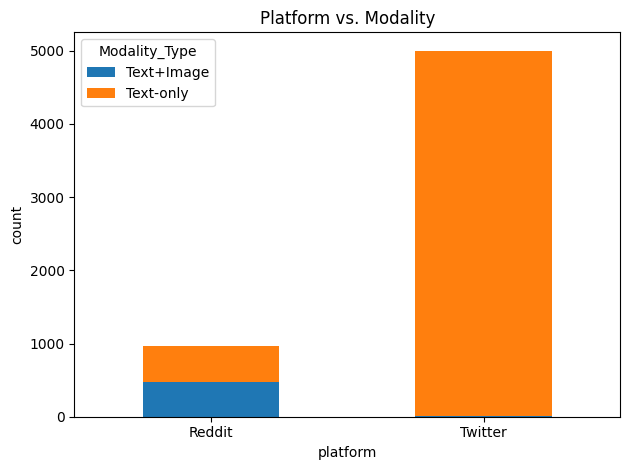

Figures saved to: /content/drive/MyDrive/msc_final_dataset/chapter4_outputs/figures


In [ ]:
import matplotlib.pyplot as plt

# Platform distribution
ax = platform_counts.plot(kind="bar", legend=False, title="Distribution by Platform", ylabel="count", xlabel="platform", rot=0)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/platform_distribution.png", dpi=300)
plt.show()

# Modality distribution
ax = modality_counts.plot(kind="bar", legend=False, title="Distribution by Modality", ylabel="count", xlabel="modality", rot=30)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/modality_distribution.png", dpi=300)
plt.show()

# Text length (words)
ax = df["text_words"].plot(kind="hist", bins=50, title="Histogram: Words per Post")
ax.set_xlabel("words per post")
ax.set_ylabel("frequency")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/textlen_words_hist.png", dpi=300)
plt.show()

# Emoji count (only rows with ≥1 emoji)
if (df["emoji_count"]>0).any():
    ax = df.loc[df["emoji_count"]>0, "emoji_count"].plot(kind="hist", bins=30, title="Histogram: Emoji Count (rows with ≥1 emoji)")
    ax.set_xlabel("emoji count per row")
    ax.set_ylabel("frequency")
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/emoji_count_hist.png", dpi=300)
    plt.show()

# Platform × Modality (stacked bars)
ax = platform_x_mod.plot(kind="bar", stacked=True, title="Platform vs. Modality", ylabel="count", xlabel="platform", rot=0)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/platform_x_modality.png", dpi=300)
plt.show()

print("Figures saved to:", FIG_DIR)

Polarity Distribution - Visuals

In [ ]:
# POLARITY SNAPSHOT (using VADER)
!pip -q install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

an = SentimentIntensityAnalyzer()

def label_vader(s: str):
    s = (s or "").strip()
    if not s: return "Neutral"
    c = an.polarity_scores(s)["compound"]
    if c >= 0.05:  return "Positive"
    if c <= -0.05: return "Negative"
    return "Neutral"

df["Polarity_Label"] = df["Text_Combined"].apply(label_vader)

pol_overall   = df["Polarity_Label"].value_counts(normalize=False).to_frame("count")
pol_platform  = (df.groupby("Social_Media_Type")["Polarity_Label"]
                 .value_counts(normalize=True)
                 .rename("proportion").round(3).to_frame())
pol_modality  = (df.groupby("Modality_Type")["Polarity_Label"]
                 .value_counts(normalize=True)
                 .rename("proportion").round(3).to_frame())

# Save into the same workbook (append)
with pd.ExcelWriter(XLSX_PATH, engine="openpyxl", mode="a", if_sheet_exists="replace") as xl:
    pol_overall.to_excel(xl, sheet_name="polarity_overall")
    pol_platform.to_excel(xl, sheet_name="polarity_by_platform")
    pol_modality.to_excel(xl, sheet_name="polarity_by_modality")

print("Polarity snapshot added to:", XLSX_PATH)
display(pol_overall)
display(pol_platform)
display(pol_modality)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 7.7 MB/s eta 0:00:00
Polarity snapshot added to: /content/drive/MyDrive/msc_final_dataset/chapter4_outputs/chapter4_descriptives.xlsx


,count
Polarity_Label,
Positive,2921
Negative,1552
Neutral,1493


proportion
Social_Media_Type Polarity_Label            
Reddit            Positive             0.552
                  Negative             0.293
                  Neutral              0.155
Twitter           Positive             0.478
                  Neutral              0.269
                  Negative             0.254

proportion
Modality_Type Polarity_Label            
Text+Image    Positive             0.527
              Neutral              0.293
              Negative             0.179
Text-only     Positive             0.486
              Negative             0.267
              Neutral              0.246

Since Reddit naturally considers subcommunities

Here is the Twitter hashtags identified:

<Figure size 1000x600 with 0 Axes>

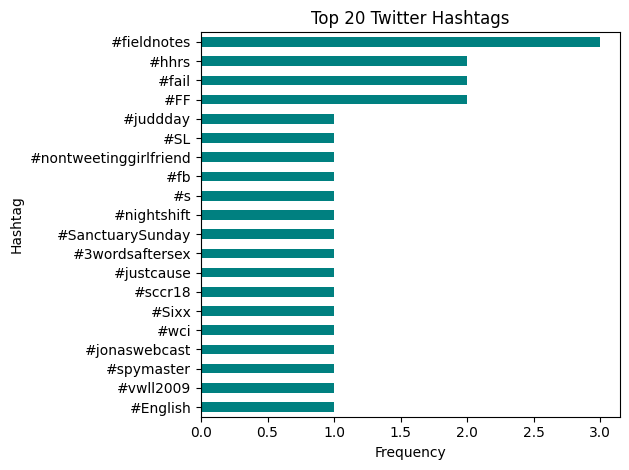

       Hashtag  Count
0  #fieldnotes      3
1        #hhrs      2
2        #fail      2
3          #FF      2
4     #juddday      1


In [ ]:
import re
import matplotlib.pyplot as plt

# Filter Twitter data
twitter_df = df[df["Social_Media_Type"] == "Twitter"].copy()

# Extract hashtags from text
twitter_df["hashtags"] = twitter_df["Text_Combined"].str.findall(r"#\w+")
hashtag_counts = twitter_df["hashtags"].explode().value_counts()

# Save top 20 hashtags to CSV
top_hashtags = hashtag_counts.head(20).reset_index()
top_hashtags.columns = ["Hashtag", "Count"]
top_hashtags.to_csv("/content/drive/MyDrive/msc_final_dataset/chapter4_outputs/top20_twitter_hashtags.csv", index=False)

# Plot
plt.figure(figsize=(10,6))
top_hashtags.plot(kind="barh", x="Hashtag", y="Count", legend=False, color="teal")
plt.gca().invert_yaxis()
plt.title("Top 20 Twitter Hashtags")
plt.xlabel("Frequency")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/msc_final_dataset/chapter4_outputs/top20_twitter_hashtags.png")
plt.show()

print(top_hashtags.head())

 Pull out themes from the Twitter subset using BERTopic

In [ ]:
# Twitter Topic Modeling with BERTopic
!pip install bertopic umap-learn hdbscan -q

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Filter Twitter posts only
twitter_df = df[df["Social_Media_Type"].str.lower() == "twitter"].copy()

# Use Text_Combined (text + OCR if available)
texts = twitter_df["Text_Combined"].dropna().astype(str).tolist()

# Init vectorizer (remove very rare and very common terms)
vectorizer_model = CountVectorizer(ngram_range=(1,2), stop_words="english", min_df=5, max_df=0.9)

# Run BERTopic
topic_model = BERTopic(vectorizer_model=vectorizer_model, language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(texts)

# Attach back to df
twitter_df["Topic"] = topics

# Get summary
topic_info = topic_model.get_topic_info()

# Top 10 topics (excluding -1 which is outliers/noise)
top_topics = topic_info[topic_info.Topic != -1].head(10)

print("=== Top Twitter Topics (pseudo-communities) ===")
print(top_topics)

# Visualize topic distribution
fig = topic_model.visualize_barchart(top_n_topics=10)
fig.show()

# Save CSV of topic assignments
out_path = "/content/drive/MyDrive/msc_final_dataset/twitter_topics.csv"
twitter_df.to_csv(out_path, index=False)
print("Saved topic-labeled Twitter subset ->", out_path)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 11.1 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
2025-09-25 16:38:07,417 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

2025-09-25 16:39:25,349 - BERTopic - Embedding - Completed ✓
2025-09-25 16:39:25,351 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-25 16:40:05,862 - BERTopic - Dimensionality - Completed ✓
2025-09-25 16:40:05,864 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-25 16:40:07,227 - BERTopic - Cluster - Completed ✓
2025-09-25 16:40:07,232 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-09-25 16:40:07,423 - BERTopic - Representation - Completed ✓


=== Top Twitter Topics (pseudo-communities) ===
    Topic  Count                                       Name  \
1       0    275                  0_movie_watching_girl_sad   
2       1    212                    1_lunch_eat_dinner_food   
3       2    180              2_twitter_tweet_world_sending   
4       3    179  3_mothers_mothers day_happy mothers_happy   
5       4    153                    4_sun_hot_weather_today   
6       5    153               5_school_bored_english_final   
7       6    124             6_song_listening_music_singing   
8       7    116                7_sleep_bed_tired_going bed   
9       8    111                     8_sucks_know_sorry_yes   
10      9     89             9_live_come_looking forward_uk   

                                       Representation  \
1   [movie, watching, girl, sad, season, watch, lo...   
2   [lunch, eat, dinner, food, eating, ate, sounds...   
3   [twitter, tweet, world, sending, goodnight, bi...   
4   [mothers, mothers day, hap

Saved topic-labeled Twitter subset -> /content/drive/MyDrive/msc_final_dataset/twitter_topics.csv


In [ ]:
# Frequency bar chart of topics
fig = topic_model.visualize_barchart(top_n_topics=10)
fig.show()

# Save outputs
fig.write_html("/content/drive/MyDrive/msc_final_dataset/twitter_topics_barchart.html")

import plotly.io as pio
pio.write_image(fig, "/content/drive/MyDrive/msc_final_dataset/twitter_topics_barchart.png", scale=2)

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


MORE visuals of Twitter top words = community

In [ ]:
# Topic distribution -
import os
import pandas as pd

OUT_DIR = "/content/drive/MyDrive/msc_final_dataset/bertopic_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# Summary info from BERTopic
topic_info = topic_model.get_topic_info()  # columns: Topic, Count, Name, Representation
# Drop outlier topic -1 (if present)
topic_info_clean = topic_info[topic_info["Topic"] != -1].copy()

# form "TopTerms" column from Representation
def top_terms(rep, k=8):
    if isinstance(rep, list):
        return ", ".join(rep[:k])
    try:
        as_list = eval(rep)
        if isinstance(as_list, list):
            return ", ".join(as_list[:k])
    except Exception:
        pass
    return str(rep)

topic_info_clean["TopTerms"] = topic_info_clean["Representation"].apply(top_terms)

# Sort by Count desc and save
topic_info_clean = topic_info_clean.sort_values("Count", ascending=False)
topic_info_clean.to_csv(f"{OUT_DIR}/twitter_topics_summary.csv", index=False)

# Quick display
topic_info_clean.head(12)

,Topic,Count,Name,Representation,Representative_Docs,TopTerms
1,0,275,0_movie_watching_girl_sad,"[movie, watching, girl, sad, season, watch, lo...",[watching the original sabrina the teenage wit...,"movie, watching, girl, sad, season, watch, lov..."
2,1,212,1_lunch_eat_dinner_food,"[lunch, eat, dinner, food, eating, ate, sounds...",[I forgot about it and I already ate lunch so...,"lunch, eat, dinner, food, eating, ate, sounds, im"
3,2,180,2_twitter_tweet_world_sending,"[twitter, tweet, world, sending, goodnight, bi...","[Twitter criado., still a newbie in twitter!, ...","twitter, tweet, world, sending, goodnight, bit..."
4,3,179,3_mothers_mothers day_happy mothers_happy,"[mothers, mothers day, happy mothers, happy, d...","[Happy Mothers Day to all the Mommies!, ay uuu...","mothers, mothers day, happy mothers, happy, da..."
5,4,153,4_sun_hot_weather_today,"[sun, hot, weather, today, gonna, outside, got...","[Where is the sun!!, sun - where are you?, it ...","sun, hot, weather, today, gonna, outside, got, yr"
6,5,153,5_school_bored_english_final,"[school, bored, english, final, summer, week, ...","[no school today! that`s greeeeeat!, its all o...","school, bored, english, final, summer, week, c..."
7,6,124,6_song_listening_music_singing,"[song, listening, music, singing, love, check,...",[why don`t you have that song you gave me that...,"song, listening, music, singing, love, check, ..."
8,7,116,7_sleep_bed_tired_going bed,"[sleep, bed, tired, going bed, early, woke, go...","[I can`t sleep... And now????, i can`t sleep. ...","sleep, bed, tired, going bed, early, woke, goo..."
9,8,111,8_sucks_know_sorry_yes,"[sucks, know, sorry, yes, ok, thats, yeah, sup...","[no way! **** that sucks B! are you ok?, Oh n...","sucks, know, sorry, yes, ok, thats, yeah, suppose"
10,9,89,9_live_come_looking forward_uk,"[live, come, looking forward, uk, seeing, comi...",[Looking forward to your gig in Ireland!!! Se...,"live, come, looking forward, uk, seeing, comin..."


Histogram - bar per topic:

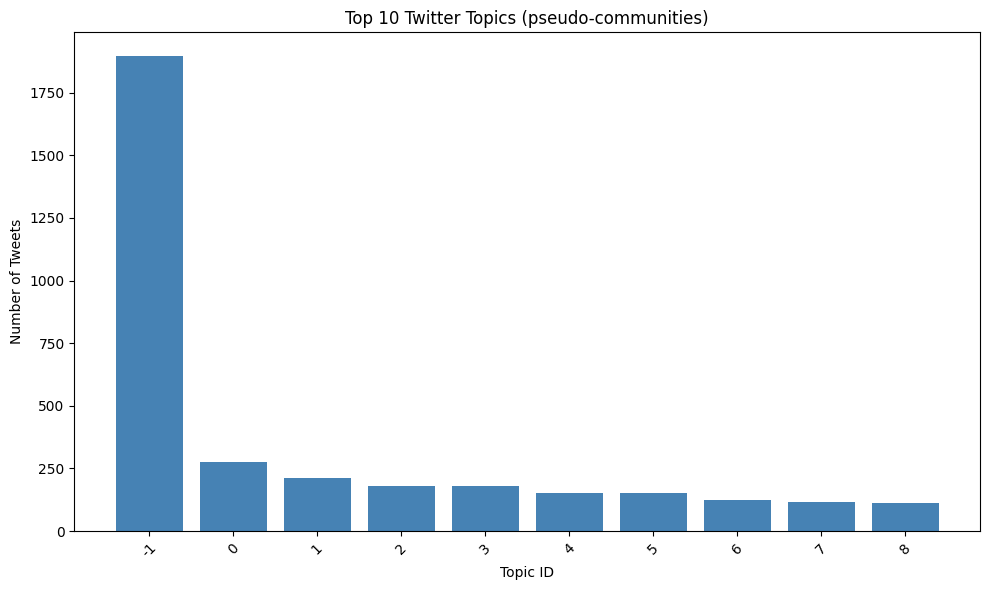

In [ ]:
import matplotlib.pyplot as plt

# Topic frequencies from BERTopic
freq = topic_model.get_topic_freq()
top10 = freq.head(10)

plt.figure(figsize=(10,6))
plt.bar(top10['Topic'].astype(str), top10['Count'], color="steelblue")
plt.title("Top 10 Twitter Topics (pseudo-communities)")
plt.xlabel("Topic ID")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig(f"{OUT_DIR}/twitter_topics_matplotlib.png", dpi=300)
plt.show()